In [2]:

import pandas as pd

In [3]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K


# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000]
test_data = data[20000:]

# Normalisation des données
scaler = StandardScaler()
train_data_x = scaler.fit_transform(train_data.drop(['anomaly', 'changepoint'], axis=1))
test_data_x = scaler.transform(test_data.drop(['anomaly', 'changepoint'], axis=1))
train_data_y = train_data[['anomaly']].values
test_data_y = test_data[['anomaly']].values


In [5]:



# Dimension de l'espace latent
input_dim = train_data_x.shape[1]
latent_dim = 4

# Encodeur
input_data = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(input_data)
h = Dense(64, activation='relu')(h)
h = Dense(32, activation='relu')(h)
h = Dense(16, activation='relu')(h)
h = Dense(8, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Echantillonnage de l'espace latent
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Décodeur
decoder_h = Dense(8, activation='relu')
decoder_h1 = Dense(16, activation='relu')
decoder_h2 = Dense(32, activation='relu')
decoder_h3 = Dense(64, activation='relu')
decoder_h4 = Dense(128, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h_decoded = decoder_h(z)
h_decoded = decoder_h1(h_decoded)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
h_decoded = decoder_h4(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

# Construction du VAE
vae = Model(input_data, x_decoded_mean)

# Définition de la perte VAE = perte de reconstruction + KL divergence
reconstruction_loss = mse(input_data, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Early stopping (optionnel)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# TensorBoard callback pour la visualisation
tensorboard_callback = TensorBoard(log_dir='./logs')

# Entraînement du modèle
epochs = 300
batch_size = 100

history = vae.fit(train_data_x, train_data_x,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(test_data_x, test_data_x),
                  callbacks=[early_stopping, tensorboard_callback])

# Définir l'encodeur
encoder = Model(input_data, z_mean)

# Définir le décodeur
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h1(_h_decoded)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h3(_h_decoded)
_h_decoded = decoder_h4(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

import os
from tensorflow.keras.models import load_model

# Définir le répertoire de sauvegarde
save_dir = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Chemins complets pour sauvegarder les modèles
vae_path = os.path.join(save_dir, 'vae_model3.h5')
encoder_path = os.path.join(save_dir, 'encoder_model3.h5')
decoder_path = os.path.join(save_dir, 'decoder_model3.h5')

# Sauvegarder les modèles
vae.save(vae_path)
encoder.save(encoder_path)
decoder.save(decoder_path)

print(f"Les modèles ont été sauvegardés dans {save_dir}")

Epoch 1/300
200/200 [==============================] - 13s 19ms/step - loss: 5.3683 - val_loss: 4.4402
Epoch 2/300
200/200 [==============================] - 3s 13ms/step - loss: 2.6681 - val_loss: 3.0898
Epoch 3/300
200/200 [==============================] - 4s 21ms/step - loss: 2.2311 - val_loss: 2.8386
Epoch 4/300
200/200 [==============================] - 4s 22ms/step - loss: 2.1025 - val_loss: 2.6919
Epoch 5/300
200/200 [==============================] - 4s 22ms/step - loss: 2.0265 - val_loss: 2.5558
Epoch 6/300
200/200 [==============================] - 3s 15ms/step - loss: 1.9713 - val_loss: 2.4673
Epoch 7/300
200/200 [==============================] - 3s 17ms/step - loss: 1.9436 - val_loss: 2.2861
Epoch 8/300
200/200 [==============================] - 3s 13ms/step - loss: 1.8955 - val_loss: 2.2577
Epoch 9/300
200/200 [==============================] - 3s 13ms/step - loss: 1.8459 - val_loss: 2.2884
Epoch 10/300
200/200 [==============================] - 3s 14ms/step - loss: 1.77

/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Les modèles ont été sauvegardés dans /home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/


78/78 [==============================] - 1s 8ms/step


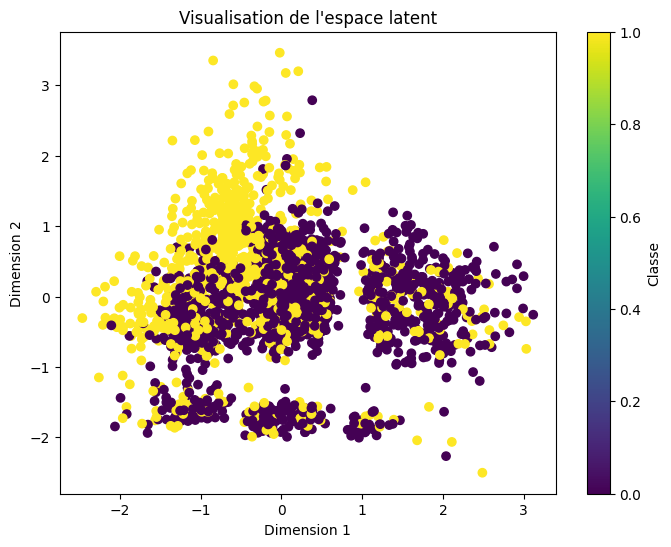

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import load_model


# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
encoder_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model3.h5'
encoder = load_model(encoder_path)

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Tracer les points de l'espace latent
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=test_data_y[:, 0], cmap='viridis')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent')
plt.colorbar(scatter, label='Classe')
plt.show()

78/78 [==============================] - 0s 6ms/step


/home/manuemk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


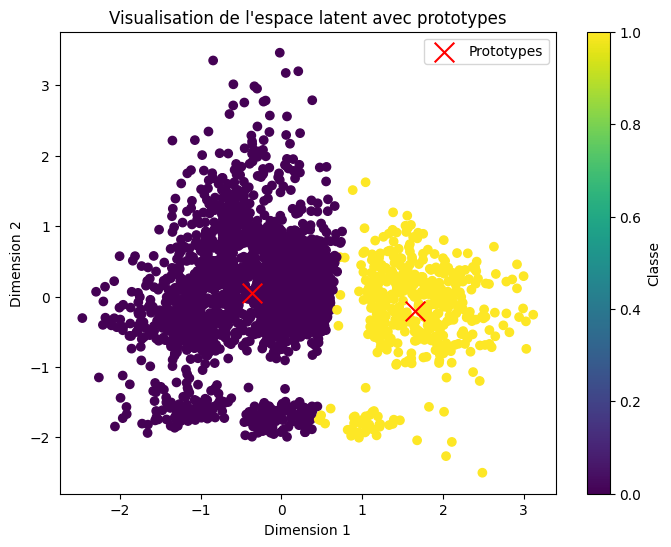

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_latent_2d)
prototypes = kmeans.cluster_centers_

# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes[:, 0], prototypes[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

78/78 [==============================] - 2s 18ms/step


TypeError: 'AgglomerativeClustering' object is not subscriptable

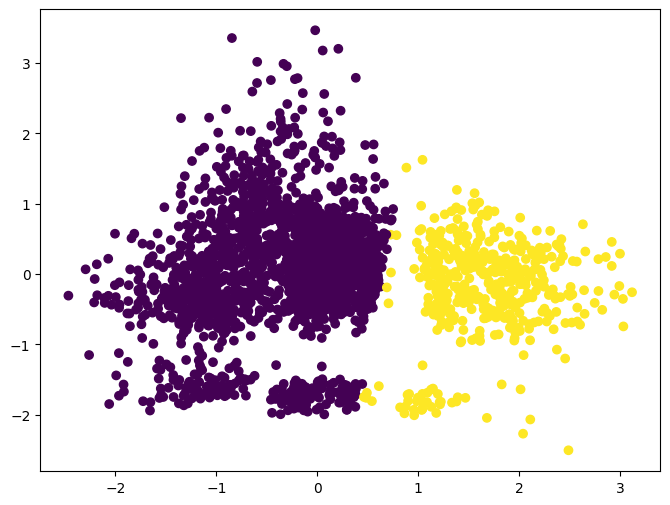

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering

# Récupérer les données d'encodage pour l'ensemble de test
test_latent = encoder.predict(test_data_x)

# Réduire la dimensionnalité de l'espace latent à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
test_latent_2d = pca.fit_transform(test_latent)

# Trouver les prototypes des différentes classes
n_clusters = len(np.unique(test_data_y))


hc = AgglomerativeClustering(n_clusters=n_clusters)
hc.fit(test_latent_2d)
prototypes = hc
# Tracer les points de l'espace latent avec les prototypes
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(test_latent_2d[:, 0], test_latent_2d[:, 1], c=kmeans.labels_, cmap='viridis')
ax.scatter(prototypes[:, 0], prototypes[:, 1], marker='x', s=200, c='red', label='Prototypes')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Visualisation de l\'espace latent avec prototypes')
plt.colorbar(scatter, label='Classe')
ax.legend()
plt.show()

In [39]:
import pandas as pd
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)


# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-03-01 15:57:02           0.080787           0.131610  1.527880 -0.273216   
2020-03-01 15:57:03           0.081003           0.128565  1.785830 -0.273216   
2020-03-01 15:57:04           0.079904           0.133247  1.510950 -0.273216   
2020-03-01 15:57:05           0.080195           0.130859  1.637560  0.054711   
2020-03-01 15:57:06         

In [40]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)


[[ 0.0764165   0.04553154  1.1337632  ...  1.03564867  0.97770943
   0.63632104]
 [ 0.07761434  0.03357089  0.82737483 ...  1.03666349 -0.7997969
   0.66172285]
 [ 0.11564941  0.04557186  0.6363226  ...  1.03791026 -0.07341779
   0.64786061]
 ...
 [-1.05857097 -0.99062324 -1.16196805 ... -1.62862464  0.45401324
  -1.3545326 ]
 [-1.05652054 -1.00666932 -0.9495032  ... -1.63048031 -0.0650372
  -1.3545326 ]
 [-1.05212305 -1.02502017 -1.05680122 ... -1.62911755 -0.31864134
  -1.3545326 ]]


In [41]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [42]:
from tensorflow.keras.losses import mse

vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model3.h5', compile=False)


reconstructions = vae.predict(X, verbose=0)
reconstruction_error = mse(reconstructions, X)
print(reconstruction_error)

tf.Tensor([0.21140955 0.22331952 0.19117256 ... 0.77800586 0.77219    0.72053272], shape=(14929,), dtype=float64)


In [43]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.211410,False
1,0.223320,False
2,0.191173,False
3,0.221708,False
4,0.284946,False


In [44]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0150	Accuracy: 0.351		Precision: 0.676	Recall Score: 0.500
Threshold: 0.0435	Accuracy: 0.399		Precision: 0.611	Recall Score: 0.530
Threshold: 0.0593	Accuracy: 0.453		Precision: 0.634	Recall Score: 0.568
Threshold: 0.0761	Accuracy: 0.503		Precision: 0.644	Recall Score: 0.601
Threshold: 0.0941	Accuracy: 0.552		Precision: 0.656	Recall Score: 0.634
Threshold: 0.1184	Accuracy: 0.595		Precision: 0.662	Recall Score: 0.658
Threshold: 0.1464	Accuracy: 0.621		Precision: 0.657	Recall Score: 0.665
Threshold: 0.1724	Accuracy: 0.635		Precision: 0.645	Recall Score: 0.659
Threshold: 0.1982	Accuracy: 0.642		Precision: 0.632	Recall Score: 0.645
Threshold: 0.2223	Accuracy: 0.646		Precision: 0.621	Recall Score: 0.628
Threshold: 0.2501	Accuracy: 0.654		Precision: 0.618	Recall Score: 0.615
Threshold: 0.2852	Accuracy: 0.659		Precision: 0.615	Recall Score: 0.598
Threshold: 0.3253	Accuracy: 0.666		Precision: 0.620	Recall Score: 0.584
Threshold: 0.4168	Accuracy: 0.661		Precision: 0.612	Recall Score

In [45]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.146391


In [46]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.211410,False,True
1,0.223320,False,True
2,0.191173,False,True
3,0.221708,False,True
4,0.284946,False,True
...,...,...,...
14924,0.761379,True,True
14925,0.714359,True,True
14926,0.778006,True,True
14927,0.772190,True,True


In [47]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.60
Taux de fausses alarmes: 0.16
Taux de manque d'alarmes: 0.52


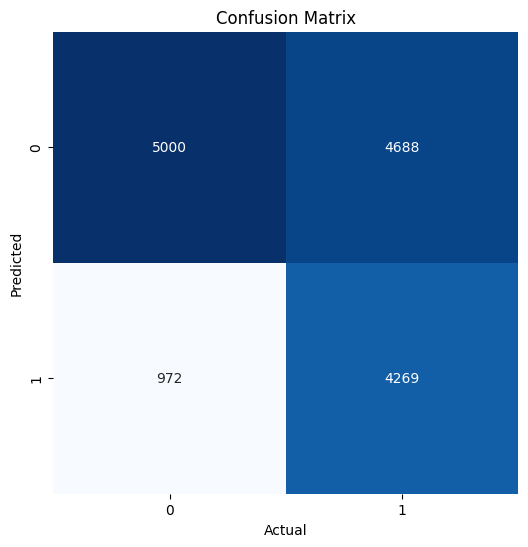

In [48]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

467/467 [==============================] - 3s 6ms/step
Threshold: 0.37185942944060935
Nombre d'anomalies détectées: 2389


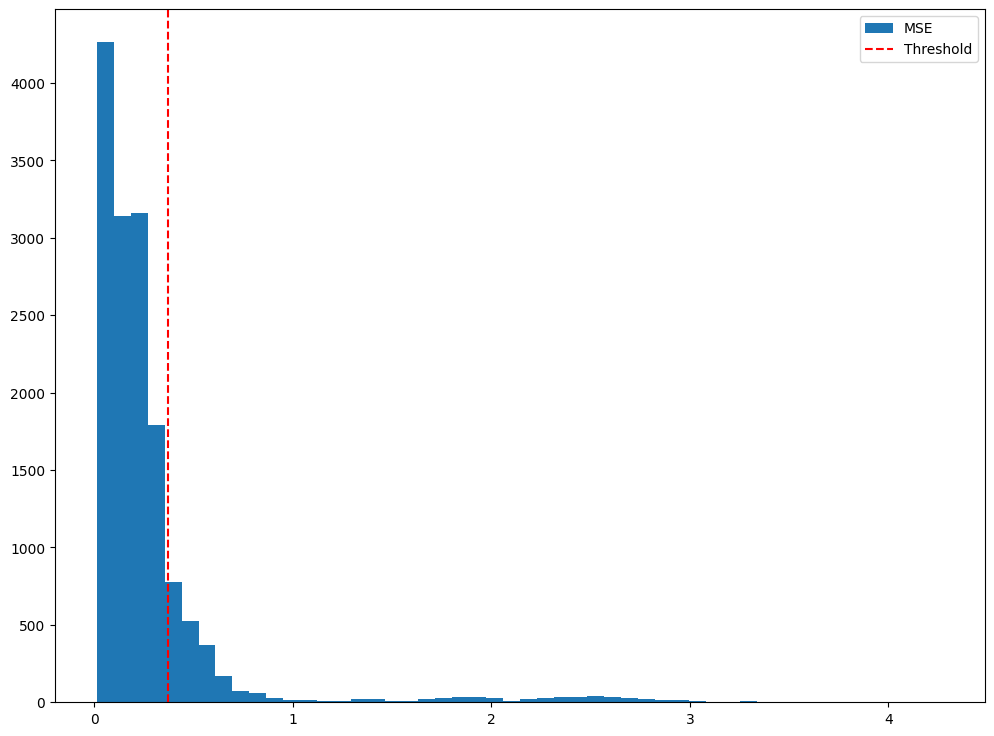

In [49]:
# Prédire les données de test et calculer l'erreur de reconstruction
X_test_pred = vae.predict(X)
mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(mse, 84)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = mse > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

# Visualiser les anomalies détectées
plt.hist(mse, bins=50, label='MSE')
plt.axvline(threshold1, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [50]:
recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.211410,False,False
1,0.223320,False,False
2,0.191173,False,False
3,0.221708,False,False
4,0.284946,False,False
...,...,...,...
14924,0.761379,True,True
14925,0.714359,True,True
14926,0.778006,True,True
14927,0.772190,True,True


In [51]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.35
Taux de fausses alarmes: 0.31
Taux de manque d'alarmes: 0.44


In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)

# Calculer le F1-score, la précision et le rappel pour différents seuils
thresholds = np.linspace(0, max(recons_df['error']), 100)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred = (recons_df['error'] > threshold).astype(int)
    f1 = f1_score(recons_df['y_true'], y_pred)
    precision = precision_score(recons_df['y_true'], y_pred)
    recall = recall_score(recons_df['y_true'], y_pred)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

# Trouver le seuil qui maximise le F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]
best_precision = precisions[best_threshold_idx]
best_recall = recalls[best_threshold_idx]

print(f"Meilleur seuil : {best_threshold:.2f}")
print(f"Meilleur F1-score : {best_f1:.2f}")
print(f"Meilleure précision : {best_precision:.2f}")
print(f"Meilleur rappel : {best_recall:.2f}")

Meilleur seuil : 0.13
Meilleur F1-score : 0.60
Meilleure précision : 0.47
Meilleur rappel : 0.85


In [53]:
recons_df1['y_pred'] = recons_df1['error'] > best_threshold
recons_df1

,error,y_true,y_pred
0,0.211410,False,True
1,0.223320,False,True
2,0.191173,False,True
3,0.221708,False,True
4,0.284946,False,True
...,...,...,...
14924,0.761379,True,True
14925,0.714359,True,True
14926,0.778006,True,True
14927,0.772190,True,True


In [54]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.60
Taux de fausses alarmes: 0.14
Taux de manque d'alarmes: 0.53


In [55]:
testt = X[0:5000, :]
print(testt)
y_testt = y[0:5000]
print(y)
print(z[0:5000])

[[ 0.0764165   0.04553154  1.1337632  ...  1.03564867  0.97770943
   0.63632104]
 [ 0.07761434  0.03357089  0.82737483 ...  1.03666349 -0.7997969
   0.66172285]
 [ 0.11564941  0.04557186  0.6363226  ...  1.03791026 -0.07341779
   0.64786061]
 ...
 [ 2.89458403  2.85268839 -0.38906655 ...  0.51235069 -0.03515855
   0.53755258]
 [ 2.90326488  2.78904835 -0.42672322 ...  0.51087196 -0.8151006
   0.60122302]
 [ 2.88687555  2.84443689  1.12881279 ...  0.51380043  1.30728551
   0.58632849]]
datetime
2020-02-08 18:10:42    False
2020-02-08 18:10:43    False
2020-02-08 18:10:44    False
2020-02-08 18:10:45    False
2020-02-08 18:10:46    False
                       ...  
2020-03-01 15:57:02     True
2020-03-01 15:57:03     True
2020-03-01 15:57:04     True
2020-03-01 15:57:05     True
2020-03-01 15:57:06     True
Name: anomaly, Length: 14929, dtype: bool
datetime
2020-02-08 18:10:42    0.0
2020-02-08 18:10:43    0.0
2020-02-08 18:10:44    0.0
2020-02-08 18:10:45    0.0
2020-02-08 18:10:46    

In [56]:
import numpy as np
from sklearn.decomposition import PCA
from keras.models import load_model

# Hypothèse : vous avez déjà entraîné votre modèle et vos prototypes
model_path = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model3.h5'
vae = load_model(model_path)
prototypes = prototypes

# Seuil de distance pour considérer une donnée comme éloignée de son prototype
distance_threshold = 2.0

def update_model_and_prototypes(X, y):
    """
    Met à jour le modèle et les prototypes de manière supervisée
    lorsqu'une donnée d'une classe est éloignée de son prototype.
    
    Args:
        X (numpy.ndarray): Données d'entrée
        y (numpy.ndarray): Étiquettes des données
    """
    # Réduire la dimensionnalité des données à 2 dimensions pour la visualisation
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # Prédire les classes des données
    y_pred = vae.predict(X)
    
    # Mettre à jour le modèle et les prototypes
    for i in range(len(X)):
        if (y[i] != y_pred[i]).all():
            # La donnée est éloignée de son prototype
            prototype = prototypes[y[i]]
            distance = np.linalg.norm(X_2d[i] - prototype)
            if distance > distance_threshold:
                # Mettre à jour le modèle et les prototypes
                vae.fit(X[i:i+1], y[i:i+1], epochs=10, batch_size=1, shuffle=True)
                prototypes[y[i]] = np.mean(X_2d[y == y[i]], axis=0)
                print(f"Donnée {i} mise à jour - Nouvelle classe: {y_pred[i]}, Nouvelle distance: {distance:.2f}")

# Tester le modèle sur les données de test
#test_data_x = test_data
y_pred = vae.predict(testt)

# Mettre à jour le modèle et les prototypes si nécessaire
update_model_and_prototypes(testt, y_testt)

157/157 [==============================] - 1s 6ms/step
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 2.5103
Epoch 2/10
1/1 [==============================] - 0s 15ms/step - loss: 1.6828
Epoch 3/10
1/1 [==============================] - 0s 10ms/step - loss: 0.7049
Epoch 4/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2039
Epoch 5/10
1/1 [==============================] - 0s 14ms/step - loss: 0.2377
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 0.5193
Epoch 7/10
1/1 [==============================] - 0s 24ms/step - loss: 0.7008
Epoch 8/10
1/1 [==============================] - 0s 14ms/step - loss: 0.6388
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 0.4381
Epoch 10/10
1/1 [==============================] - 0s 17ms/step - loss: 0.2761
Donnée 573 mise à jour - Nouvelle classe: [-0.20087057  0.13602695  1.4222031  -1.3334458  -0.16533223 -0.13966744
  1.3732435   0.45673868], Nouvelle distance: 3.41


KeyboardInterrupt: 

In [ ]:
print(y_pred)

[[0.2491039  0.23610702 0.8232403  ... 0.6258608  0.69500744 0.82267255]
 [0.25785527 0.23935638 0.7456722  ... 0.6171653  0.35927606 0.8223808 ]
 [0.2481243  0.23470454 0.7458976  ... 0.62417024 0.5258138  0.8270155 ]
 ...
 [0.27332446 0.24196741 0.5931405  ... 0.57183725 0.47645676 0.8277578 ]
 [0.2740955  0.24160986 0.56984586 ... 0.56635463 0.34487152 0.83509696]
 [0.27106488 0.24224983 0.8575763  ... 0.56177944 0.7743679  0.82841945]]


In [ ]:
len(y_pred)

print(y_pred[1])

[0.25785527 0.23935638 0.7456722  0.48126546 0.39416748 0.6171653
 0.35927606 0.8223808 ]


In [ ]:
from tensorflow.keras.losses import mse

reconstruction_error = mse(y_pred, testt)
print(reconstruction_error)

tf.Tensor([0.01848537 0.01868571 0.01810482 ... 0.10035314 0.09883136 0.10045849], shape=(5000,), dtype=float64)


In [ ]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_testt
}).reset_index(drop=True)

In [ ]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0018	Accuracy: 0.361		Precision: 0.680	Recall Score: 0.500


Threshold: 0.0032	Accuracy: 0.425		Precision: 0.684	Recall Score: 0.550
Threshold: 0.0034	Accuracy: 0.484		Precision: 0.686	Recall Score: 0.593
Threshold: 0.0036	Accuracy: 0.536		Precision: 0.687	Recall Score: 0.630
Threshold: 0.0037	Accuracy: 0.579		Precision: 0.684	Recall Score: 0.656
Threshold: 0.0039	Accuracy: 0.609		Precision: 0.675	Recall Score: 0.669
Threshold: 0.0041	Accuracy: 0.641		Precision: 0.676	Recall Score: 0.684
Threshold: 0.0046	Accuracy: 0.674		Precision: 0.684	Recall Score: 0.698
Threshold: 0.0081	Accuracy: 0.672		Precision: 0.663	Recall Score: 0.676
Threshold: 0.0104	Accuracy: 0.671		Precision: 0.649	Recall Score: 0.655
Threshold: 0.0176	Accuracy: 0.697		Precision: 0.670	Recall Score: 0.663
Threshold: 0.0197	Accuracy: 0.715		Precision: 0.692	Recall Score: 0.663
Threshold: 0.0221	Accuracy: 0.735		Precision: 0.736	Recall Score: 0.664
Threshold: 0.0239	Accuracy: 0.747		Precision: 0.813	Recall Score: 0.657
Threshold: 0.0997	Accuracy: 0.706		Precision: 0.843	Recall Score

In [ ]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.004585


In [ ]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.018485,False,True
1,0.018686,False,True
2,0.018105,False,True
3,0.018338,False,True
4,0.016912,False,True
...,...,...,...
4995,0.100275,True,True
4996,0.097397,True,True
4997,0.100353,True,True
4998,0.098831,True,True


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que recons_df1 est déjà défini avec les colonnes 'y_true' et 'y_pred'

# Calculer la matrice de confusion
cm = confusion_matrix(recons_df['y_true'], recons_df['predicted_anomaly'])

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

# Calculer le F1-score
f1 = f1_score(recons_df['y_true'], recons_df['predicted_anomaly'])

# Calculer le taux de faux positifs et faux négatifs
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # Taux de faux positifs
fnr = fn / (fn + tp)  # Taux de faux négatifs

print(f"F1-score : {f1:.4f}")
print(f"Taux de faux positifs(fausses alarmes) : {fpr:.2f}")
print(f"Taux de faux négatifs(manque d'alarmes) : {fnr:.2f}")

KeyError: 'predicted_anomaly'

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.61
Taux de fausses alarmes: 0.20
Taux de manque d'alarmes: 0.46


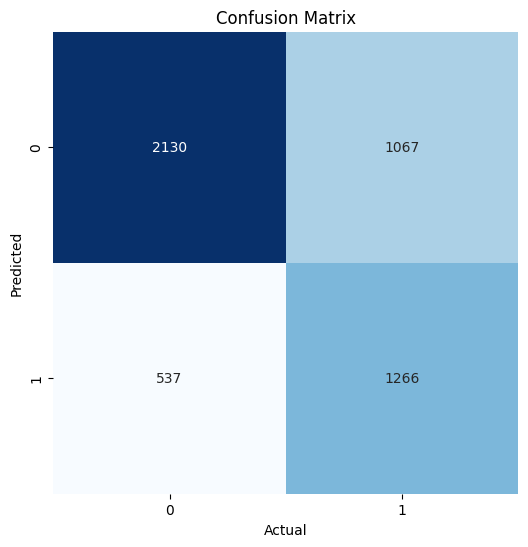

In [ ]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Prédire les données de test et calculer l'erreur de reconstruction
#X_test_pred = vae.predict(X)
#mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(reconstruction_error, 84)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = reconstruction_error > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")



Threshold: 0.5578566733217832
Nombre d'anomalies détectées: 800


In [ ]:
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_testt
}).reset_index(drop=True)


recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.175767,False,False
1,0.277516,False,False
2,0.245860,False,False
3,0.228168,False,False
4,0.214701,False,False
...,...,...,...
4995,0.855283,True,True
4996,0.470074,True,False
4997,0.497223,True,False
4998,0.528050,True,False


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.36
Taux de fausses alarmes: 0.32
Taux de manque d'alarmes: 0.41


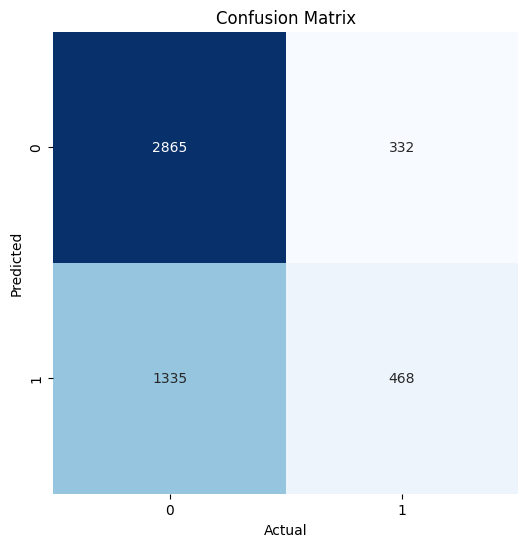

In [ ]:
cm = confusion_matrix(recons_df1['y_true'],recons_df1['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()